In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit 
import pandas as pd
import matplotlib.pyplot as plt
import random
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

random.seed(1)# setting random seed
main_data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

In [2]:
cancerTypes = ['epithelial', 'inflammatory', 'fibroblast', 'others']
cancerous = ["Y", "N"]

one_hot = pd.get_dummies(main_data['cellTypeName'])
main_data = main_data.drop('cellTypeName',axis = 1)
main_data = main_data.join(one_hot)
main_data

,InstanceID,patientID,ImageName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others
0,22405,1,22405.png,0,0,0,1,0,0
1,22406,1,22406.png,0,0,0,1,0,0
2,22407,1,22407.png,0,0,0,1,0,0
3,22408,1,22408.png,0,0,0,1,0,0
4,22409,1,22409.png,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9891,1625,60,1625.png,2,1,1,0,0,0
9892,1626,60,1626.png,2,1,1,0,0,0
9893,1627,60,1627.png,2,1,1,0,0,0
9894,1628,60,1628.png,2,1,1,0,0,0


In [3]:
main_data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellType        0
isCancerous     0
epithelial      0
fibroblast      0
inflammatory    0
others          0
dtype: int64

In [4]:
gs_1 = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
train_test_ix, val_ix = next(gs_1.split(main_data, groups=main_data["patientID"]))
train_test = main_data.loc[train_test_ix]
val = main_data.loc[val_ix]

train_test = train_test.reset_index(drop=True)
gs_2 = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=42)
train_ix, test_ix = next(gs_2.split(train_test, groups=train_test["patientID"]))
train = train_test.loc[train_ix]
test = train_test.loc[test_ix]

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70')])

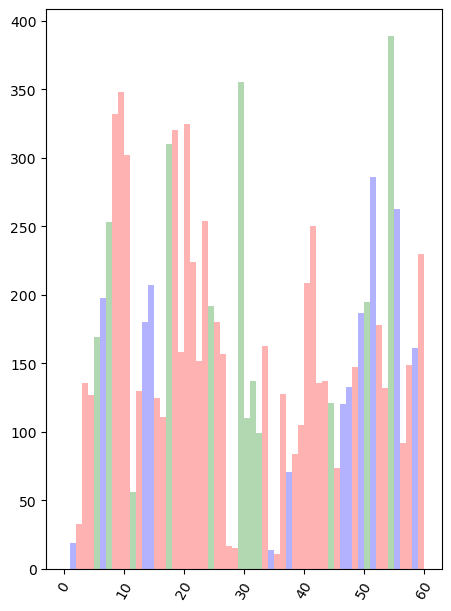

In [5]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.tight_layout(pad=4.0)
plt.hist(x=train['patientID'], alpha=0.3, color='r', bins=60,range=(0,60))
plt.hist(x=val['patientID'], alpha=0.3, color='b', bins=60, range=(0,60))
plt.hist(x=test['patientID'], alpha=0.3, color='g', bins=60, range=(0,60))
plt.xticks(rotation=60)

In [6]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4
BATCH_SIZE = 256
EPOCHS = 64
LEARNING_RATE = 0.00075
REGULARISATION_LAMBDA = 0.01

In [7]:
#Using built-in tensorflow metrics

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

    

#train_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# Training data generator with augmentation
train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        data_format='channels_last')

val_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Setting up the generators
# train_generator = train_gen.flow_from_dataframe(
#         dataframe=train,
#         directory='./Image_classification_data/patch_images',
#         x_col="ImageName",
#         y_col=['epithelial', 'inflammatory', 'fibroblast', 'others'],
#         target_size=(27, 27),
#         batch_size=BATCH_SIZE,
#         class_mode='raw')

#Train generator with augementation
train_generator = train_gen.flow_from_dataframe(
        dataframe=train,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col=['epithelial', 'inflammatory', 'fibroblast', 'others'],
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='raw')

validation_generator = val_gen.flow_from_dataframe(
        dataframe=val,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col=['epithelial', 'inflammatory', 'fibroblast', 'others'],
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='raw')

test_generator = test_gen.flow_from_dataframe(
        dataframe=test,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col=['epithelial', 'inflammatory', 'fibroblast', 'others'],
        target_size=(27, 27),
        batch_size=1,
        class_mode='raw')

Found 5671 validated image filenames.
Found 1839 validated image filenames.
Found 2386 validated image filenames.


# Baseline

In [9]:
model = tf.keras.Sequential([
    layers.Flatten(input_shape=INPUT_DIM),
    layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
    layers.Dense(OUTPUT_CLASSES, activation="softmax")
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


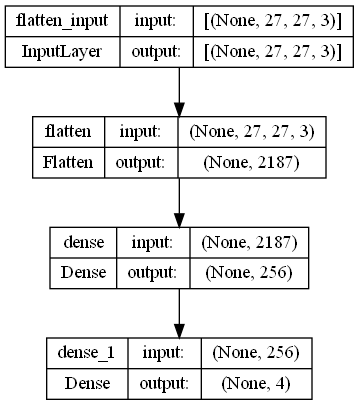

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
from keras.optimizers import SGD
opt = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer = opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.CategoricalAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()
              ]
             )

history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS)

Epoch 1/64
23/23 [==============================] - 8s 315ms/step - loss: 1.2988 - categorical_accuracy: 0.4013 - precision: 0.5000 - recall: 5.2901e-04 - val_loss: 1.2349 - val_categorical_accuracy: 0.5008 - val_precision: 0.8824 - val_recall: 0.0082
Epoch 2/64
23/23 [==============================] - 6s 250ms/step - loss: 1.2819 - categorical_accuracy: 0.4080 - precision: 0.7143 - recall: 0.0018 - val_loss: 1.2355 - val_categorical_accuracy: 0.5041 - val_precision: 0.9091 - val_recall: 0.0054
Epoch 3/64
23/23 [==============================] - 7s 302ms/step - loss: 1.2738 - categorical_accuracy: 0.4142 - precision: 0.6667 - recall: 0.0018 - val_loss: 1.2172 - val_categorical_accuracy: 0.5122 - val_precision: 0.8636 - val_recall: 0.0103
Epoch 4/64
23/23 [==============================] - 7s 302ms/step - loss: 1.2656 - categorical_accuracy: 0.4216 - precision: 0.7097 - recall: 0.0039 - val_loss: 1.2204 - val_categorical_accuracy: 0.5247 - val_precision: 1.0000 - val_recall: 0.0071
Epoc

Epoch 34/64
23/23 [==============================] - 7s 333ms/step - loss: 1.1637 - categorical_accuracy: 0.5301 - precision: 0.8319 - recall: 0.1405 - val_loss: 1.1203 - val_categorical_accuracy: 0.6607 - val_precision: 0.9502 - val_recall: 0.1039
Epoch 35/64
23/23 [==============================] - 7s 315ms/step - loss: 1.1634 - categorical_accuracy: 0.5262 - precision: 0.8403 - recall: 0.1485 - val_loss: 1.1261 - val_categorical_accuracy: 0.6558 - val_precision: 0.9615 - val_recall: 0.0816
Epoch 36/64
23/23 [==============================] - 7s 311ms/step - loss: 1.1632 - categorical_accuracy: 0.5387 - precision: 0.8309 - recall: 0.1481 - val_loss: 1.1341 - val_categorical_accuracy: 0.6591 - val_precision: 0.9606 - val_recall: 0.0663
Epoch 37/64
23/23 [==============================] - 5s 226ms/step - loss: 1.1592 - categorical_accuracy: 0.5428 - precision: 0.8440 - recall: 0.1488 - val_loss: 1.1009 - val_categorical_accuracy: 0.6596 - val_precision: 0.9296 - val_recall: 0.1365
Epoc

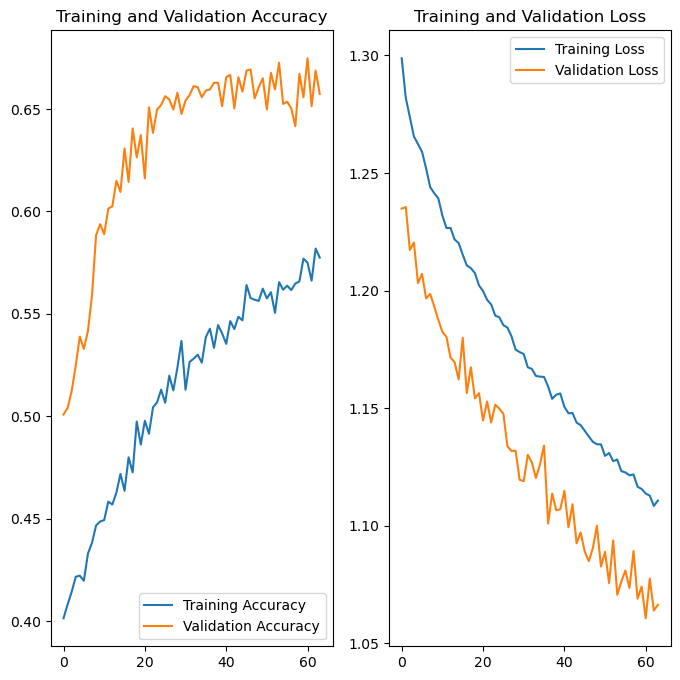

In [13]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# CNN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(REGULARISATION_LAMBDA)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(REGULARISATION_LAMBDA)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(REGULARISATION_LAMBDA)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(REGULARISATION_LAMBDA)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(REGULARISATION_LAMBDA)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(REGULARISATION_LAMBDA)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                      

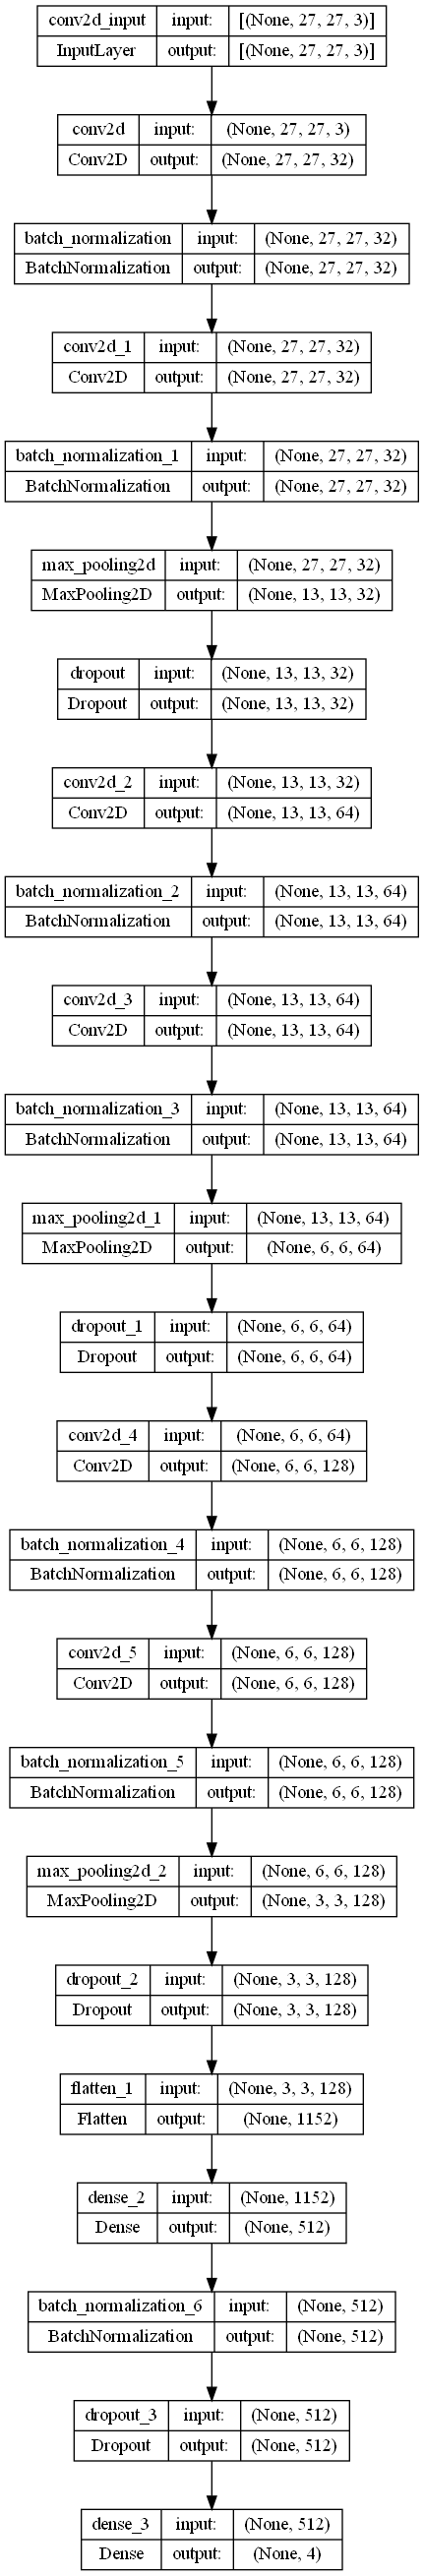

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
# Import the Adam optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer = opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.CategoricalAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()
              ]
             )

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    mode='min',  # We seek to minimize the validation loss
    patience=20,  # Number of epochs to wait without improvement before stopping the training
    verbose=1,
    restore_best_weights=True  # Restore the best weights recorded during training
)

# Add this callback to the list of callbacks passed to the model during training
history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=EPOCHS, 
    callbacks=[early_stopping_callback]  # Pass the callback here
)

num_epochs_run = len(history.history['loss'])

#history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS)

Epoch 1/64
23/23 [==============================] - 13s 424ms/step - loss: 11.5976 - categorical_accuracy: 0.5604 - precision_1: 0.5872 - recall_1: 0.5322 - val_loss: 11.0100 - val_categorical_accuracy: 0.5030 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/64
23/23 [==============================] - 7s 309ms/step - loss: 10.2295 - categorical_accuracy: 0.6383 - precision_1: 0.6600 - recall_1: 0.6075 - val_loss: 10.1285 - val_categorical_accuracy: 0.5030 - val_precision_1: 0.5030 - val_recall_1: 0.5030
Epoch 3/64
23/23 [==============================] - 9s 363ms/step - loss: 9.0305 - categorical_accuracy: 0.6729 - precision_1: 0.7001 - recall_1: 0.6327 - val_loss: 9.2443 - val_categorical_accuracy: 0.5030 - val_precision_1: 0.5030 - val_recall_1: 0.5030
Epoch 4/64
23/23 [==============================] - 9s 371ms/step - loss: 7.9751 - categorical_accuracy: 0.6948 - precision_1: 0.7257 - recall_1: 0.6526 - val_loss: 8.5574 - val_categorical_accuracy: 0.5030 - val_precis

Epoch 33/64
23/23 [==============================] - 7s 306ms/step - loss: 1.0151 - categorical_accuracy: 0.8004 - precision_1: 0.8353 - recall_1: 0.7665 - val_loss: 1.6893 - val_categorical_accuracy: 0.5111 - val_precision_1: 0.5750 - val_recall_1: 0.4546
Epoch 34/64
23/23 [==============================] - 9s 374ms/step - loss: 0.9957 - categorical_accuracy: 0.7979 - precision_1: 0.8314 - recall_1: 0.7582 - val_loss: 2.2742 - val_categorical_accuracy: 0.5334 - val_precision_1: 0.5484 - val_recall_1: 0.5052
Epoch 35/64
23/23 [==============================] - 9s 380ms/step - loss: 0.9770 - categorical_accuracy: 0.7997 - precision_1: 0.8328 - recall_1: 0.7614 - val_loss: 2.5152 - val_categorical_accuracy: 0.5595 - val_precision_1: 0.5805 - val_recall_1: 0.5449
Epoch 36/64
23/23 [==============================] - 7s 302ms/step - loss: 0.9472 - categorical_accuracy: 0.7970 - precision_1: 0.8293 - recall_1: 0.7581 - val_loss: 1.2707 - val_categorical_accuracy: 0.6465 - val_precision_1: 0.

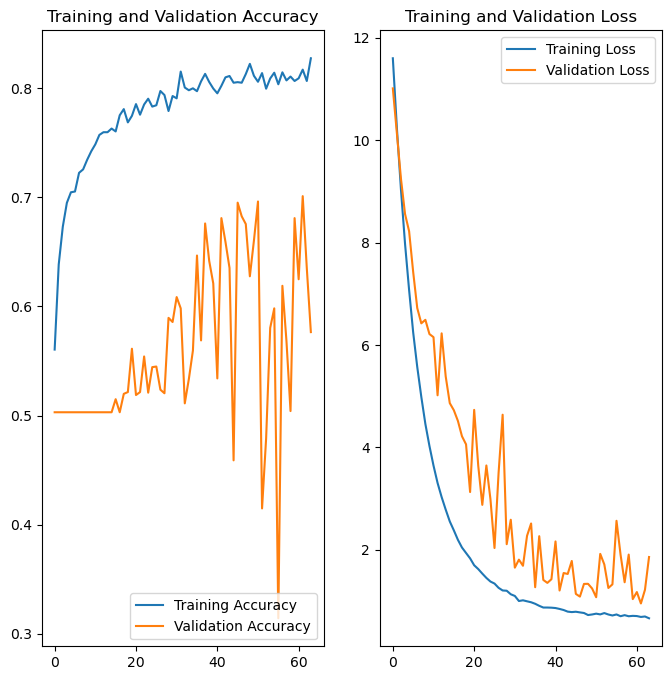

In [18]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs_run)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# Print training accuracy and loss over epochs
for epoch in range(num_epochs_run):
    print(f"Epoch {epoch+1}/{num_epochs_run}")
    print(f"Train Accuracy: {history.history['categorical_accuracy'][epoch]}")
    print(f"Validation Accuracy: {history.history['val_categorical_accuracy'][epoch]}")
    print(f"Train Loss: {history.history['loss'][epoch]}")
    print(f"Validation Loss: {history.history['val_loss'][epoch]}")
    print("\n")

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=128)
print("Test loss, Test acc:", results)

Epoch 1/64
Train Accuracy: 0.5603950023651123
Validation Accuracy: 0.5029907822608948
Train Loss: 11.597579956054688
Validation Loss: 11.01000690460205


Epoch 2/64
Train Accuracy: 0.6383354067802429
Validation Accuracy: 0.5029907822608948
Train Loss: 10.229524612426758
Validation Loss: 10.128506660461426


Epoch 3/64
Train Accuracy: 0.672897219657898
Validation Accuracy: 0.5029907822608948
Train Loss: 9.030517578125
Validation Loss: 9.244274139404297


Epoch 4/64
Train Accuracy: 0.6947628259658813
Validation Accuracy: 0.5029907822608948
Train Loss: 7.975052833557129
Validation Loss: 8.557416915893555


Epoch 5/64
Train Accuracy: 0.7044612765312195
Validation Accuracy: 0.5029907822608948
Train Loss: 7.072838306427002
Validation Loss: 8.220782279968262


Epoch 6/64
Train Accuracy: 0.7051666378974915
Validation Accuracy: 0.5029907822608948
Train Loss: 6.246673583984375
Validation Loss: 7.426024913787842


Epoch 7/64
Train Accuracy: 0.722271203994751
Validation Accuracy: 0.502990782260894

2386/2386 [==============================] - 21s 9ms/step - loss: 1.4095 - categorical_accuracy: 0.6655 - precision_1: 0.6826 - recall_1: 0.6417
Test loss, Test acc: [1.4094864130020142, 0.6655490398406982, 0.6825680136680603, 0.641659677028656]


# Overfitting